<a href="https://colab.research.google.com/github/Witcape/3D_Printing/blob/main/SWIN_CLAHE_FINAL_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/AarohiSingla/Swin-Transformer
%cd Swin-Transformer

Cloning into 'Swin-Transformer'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 24 (delta 4), reused 17 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 1.38 MiB | 8.84 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/Swin-Transformer


In [3]:
!pip install timm
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 29.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
def window_partition(x, patch_size=4):
    """
    Args:
        x: (B, H, W, C)
        patch_size (int): patch size (Default: 4)

    Returns:
        patches: (num_patches * B, patch_size, patch_size, C)
                 (num_windows * B, patch_size, patch_size, C)
    """

    B, H, W, C = x.shape

    # Calculate the number of patches in each dimension
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size

    # Convert to (B, num_patches_h, patch_size, num_patches_w, patch_size, C)
    x = x.view(B, num_patches_h, patch_size, num_patches_w, patch_size, C)

    # Convert to (B, num_patches_h, num_patches_w, patch_size, patch_size, C)
    patches = x.permute(0, 1, 3, 2, 4, 5).contiguous()

    # Efficient Batch Computation - Convert to (B * num_patches_h * num_patches_w, patch_size, patch_size, C)
    patches = patches.view(-1, patch_size, patch_size, C)

    return patches

In [5]:
# Lets use PatchEmbed

class PatchEmbed(nn.Module):
    """ Convert image to patch embedding

    Args:
        img_size (int): Image size (Default: 224)
        patch_size (int): Patch token size (Default: 4)
        in_channels (int): Number of input image channels (Default: 3)
        embed_dim (int): Number of linear projection output channels (Default: 96)
        norm_layer (nn.Module, optional): Normalization layer (Default: None)
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size) # (img_size, img_size) to_2tuple simply convert t to (t,t)
        patch_size = to_2tuple(patch_size) # (patch_size, patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]] # (num_patches, num_patches)

        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        # proj layer: (B, 3, 224, 224) -> (B, 96, 56, 56)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        """
        x: (B, C, H, W) Default: (B, 3, 224, 224)
        returns: (B, H//patch_size * W//patch_size, embed_dim) (B, 56*56, 96)
        """
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}]) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."

        # (B, 3, 224, 224) -> (B, 96, 56, 56)
        x = self.proj(x)

        # (B, 96, 56, 56) -> (B, 96, 56*56)
        x = x.flatten(2)

        # (B, 96, 56*56) -> (B, 56*56, 96): 56 refers to the number of patches
        x = x.transpose(1, 2)

        if self.norm is not None:
            x = self.norm(x)

        return x

In [6]:
# Load the image file
image_path = '/content/test.png'
image = Image.open(image_path)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])

# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

patch_embed = PatchEmbed(img_size=224, patch_size=4, in_chans=3, embed_dim=96)

embedding = patch_embed(tensor_image)


patches = patch_embed(tensor_image)
# Print the shape of the output patches
print("Patches shape:", patches.shape)   # 96 is embedding dimension, 3136 patches 224/4 * 224/4

embedding

Patches shape: torch.Size([1, 3136, 96])


tensor([[[-0.0440, -0.0032,  0.0594,  ...,  0.4580, -0.5196, -0.3302],
         [-0.0440, -0.0032,  0.0594,  ...,  0.4580, -0.5196, -0.3302],
         [-0.0440, -0.0032,  0.0594,  ...,  0.4580, -0.5196, -0.3302],
         ...,
         [-0.0440, -0.0032,  0.0594,  ...,  0.4580, -0.5196, -0.3302],
         [-0.0440, -0.0032,  0.0594,  ...,  0.4580, -0.5196, -0.3302],
         [-0.0440, -0.0032,  0.0594,  ...,  0.4580, -0.5196, -0.3302]]],
       grad_fn=<TransposeBackward0>)

In [7]:
from swin_functions_and_classes import *

stage_1 = BasicLayer(dim=96, input_resolution=(56, 56), depth=2, num_heads=4, window_size=7)

# Pass the patch embeddings through the BasicLayer
output = stage_1(embedding)
print(output.shape)
output

torch.Size([1, 3136, 96])


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[[-0.6860, -0.2355,  0.0536,  ...,  0.2479,  0.2135, -0.2625],
         [-0.6860, -0.2355,  0.0536,  ...,  0.2479,  0.2135, -0.2625],
         [-0.6860, -0.2355,  0.0536,  ...,  0.2479,  0.2135, -0.2625],
         ...,
         [-0.6860, -0.2355,  0.0536,  ...,  0.2479,  0.2135, -0.2625],
         [-0.6860, -0.2355,  0.0536,  ...,  0.2479,  0.2135, -0.2625],
         [-0.6860, -0.2355,  0.0536,  ...,  0.2479,  0.2135, -0.2625]]],
       grad_fn=<AddBackward0>)

In [8]:
# Create an instance of the SwinTransformerBlock class with the desired parameters
block_1 = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=0,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


#  shift_size is set to 3
block_1_shf = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=2,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


# Pass the embedding through the SwinTransformerBlock:
output = block_1(embedding)
output_shf = block_1_shf(embedding)

print(output.shape)
print(output_shf.shape)
print(output)
print(output_shf)

torch.Size([1, 3136, 96])
torch.Size([1, 3136, 96])
tensor([[[-0.3420,  0.3193, -0.3437,  ...,  0.7042, -0.1449,  0.0484],
         [-0.3420,  0.3193, -0.3437,  ...,  0.7042, -0.1449,  0.0484],
         [-0.3420,  0.3193, -0.3437,  ...,  0.7042, -0.1449,  0.0484],
         ...,
         [-0.3420,  0.3193, -0.3437,  ...,  0.7042, -0.1449,  0.0484],
         [-0.3420,  0.3193, -0.3437,  ...,  0.7042, -0.1449,  0.0484],
         [-0.3420,  0.3193, -0.3437,  ...,  0.7042, -0.1449,  0.0484]]],
       grad_fn=<AddBackward0>)
tensor([[[ 0.0139,  0.1445, -0.1583,  ...,  0.7405, -0.7045, -0.3625],
         [ 0.0139,  0.1445, -0.1583,  ...,  0.7405, -0.7045, -0.3625],
         [ 0.0139,  0.1445, -0.1583,  ...,  0.7405, -0.7045, -0.3625],
         ...,
         [ 0.0139,  0.1445, -0.1583,  ...,  0.7405, -0.7045, -0.3625],
         [ 0.0139,  0.1445, -0.1583,  ...,  0.7405, -0.7045, -0.3625],
         [ 0.0139,  0.1445, -0.1583,  ...,  0.7405, -0.7045, -0.3625]]],
       grad_fn=<AddBackward0>)


In [9]:
model = SwinTransformer()

print(tensor_image.shape)

model(tensor_image).shape

torch.Size([1, 3, 224, 224])


torch.Size([1, 1000])

In [10]:
train_dir = '/content/drive/MyDrive/Final_Final/Train'
test_dir = '/content/drive/MyDrive/Final_Final/Test'

In [11]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [12]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [13]:
# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b73fdc76d10>,
 ['Normal', 'Shaghetti', 'Stringing'])

torch.Size([3, 224, 224]) tensor(1)


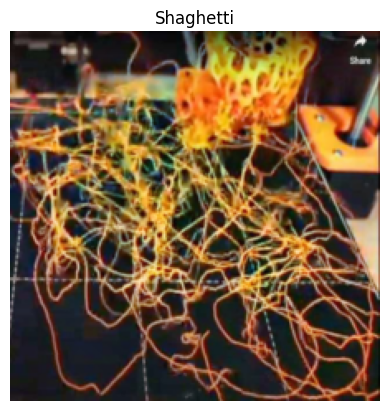

In [14]:
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [15]:
model = SwinTransformer(num_classes=len(class_names))

In [16]:
from going_modular.going_modular import engine
from helper_functions import set_seeds

device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

In [17]:
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1070 | train_acc: 0.3783 | test_loss: 1.5202 | test_acc: 0.3606
Epoch: 2 | train_loss: 1.2912 | train_acc: 0.3203 | test_loss: 1.1944 | test_acc: 0.3606
Epoch: 3 | train_loss: 1.1576 | train_acc: 0.3650 | test_loss: 1.1545 | test_acc: 0.3990
Epoch: 4 | train_loss: 1.1224 | train_acc: 0.3996 | test_loss: 1.2929 | test_acc: 0.3990
Epoch: 5 | train_loss: 1.1789 | train_acc: 0.4096 | test_loss: 1.4035 | test_acc: 0.3606
Epoch: 6 | train_loss: 1.1704 | train_acc: 0.3493 | test_loss: 1.1476 | test_acc: 0.3990
Epoch: 7 | train_loss: 1.1485 | train_acc: 0.3504 | test_loss: 1.0983 | test_acc: 0.3606
Epoch: 8 | train_loss: 1.0898 | train_acc: 0.3761 | test_loss: 1.0918 | test_acc: 0.3990
Epoch: 9 | train_loss: 1.1015 | train_acc: 0.3705 | test_loss: 1.0925 | test_acc: 0.3606
Epoch: 10 | train_loss: 1.1031 | train_acc: 0.3717 | test_loss: 1.1423 | test_acc: 0.3990


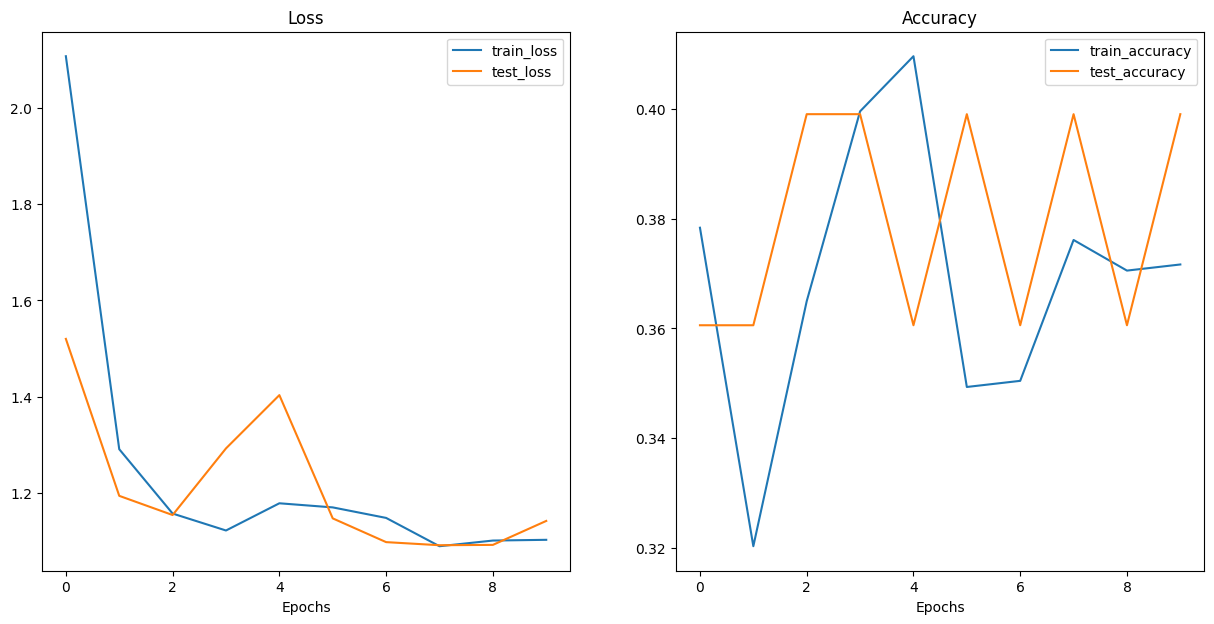

In [20]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

In [21]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/MyDrive/Final_Cropped/Test/Normal/OK_0_jpg.rf.740ffa606b739c94466610526a036de5.jpg"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Final_Cropped/Test/Normal/OK_0_jpg.rf.740ffa606b739c94466610526a036de5.jpg'

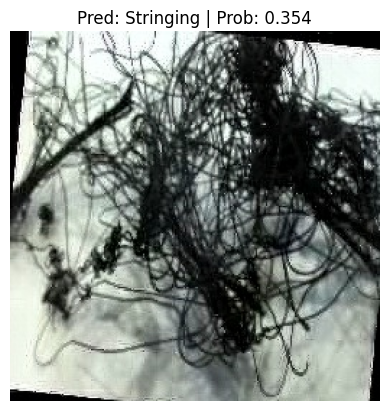

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/MyDrive/Final_Cropped/Test/Spaghetti/FM637CFIHF6MY36_jpg.rf.e2c23511d4e2fd564d4d7079b1bf28b2.jpg"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

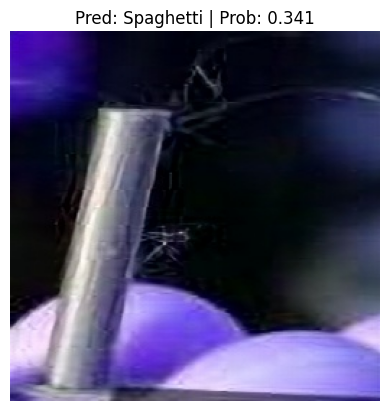

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/MyDrive/Final_Cropped/Test/Stringing/Capture-d-ecran-649-_jpg.rf.2b3ff608b0b53eb78c5f578877320979.jpg"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

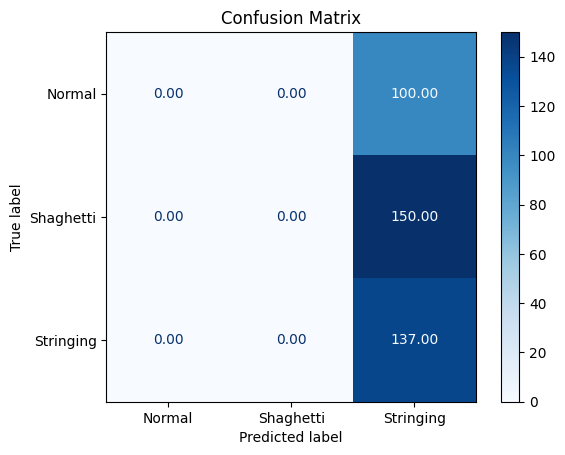

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Function to get all predictions and true labels from the test dataloader
def get_predictions(model, test_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)  # Move to the appropriate device
            outputs = model(images)  # Get model predictions
            _, preds = torch.max(outputs, 1)  # Get the predicted class indices

            all_preds.extend(preds.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())  # Store true labels

    return np.array(all_labels), np.array(all_preds)

# Get true labels and predictions
true_labels, predictions = get_predictions(model, test_dataloader, device)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', values_format='.2f')  # You can customize the color map and format
plt.title('Confusion Matrix')
plt.show()